### Problem Statement
Apply Machine Learning techniques to produce a model able to predict if a comment will be perceived as toxic or not toxic

#### 1. Install Requirements for the project

In [339]:
# !pip install -r requirements.txt
# print('Library in In Requirements.txt:')
# !cat requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC 

Library in In Requirements.txt:
pandas
matplotlib
sklearn
numpy
seaborn
xgboost


#### 2. A Quick Exploratory Data Analysis (EDA)

In [387]:
data = pd.read_csv('toxicity_xls.csv')
print('Shape of the data is {}'.format(data.shape))
print(80*'%')
print('Sample \n',data.head(5))
print(80*'%')
print('Variables Distribution \n',data.describe())

Shape of the data is (12000, 7)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sample 
    flirtation  identity_attack    insult  severe_toxicity  sexually_explicit  \
0    0.593828         0.563516  0.849090         0.864632           0.777347   
1    0.213193         0.407253  0.925010         0.856451           0.456983   
2    0.474532         0.323574  0.710831         0.747318           0.933715   
3    0.503426         0.407557  0.796685         0.854638           0.955973   
4    0.394807         0.170078  0.561849         0.766563           0.459300   

     threat           label  
0  0.602494       Offensive  
1  0.592931       Offensive  
2  0.208848  Very offensive  
3  0.343336         Neutral  
4  0.223698       Profanity  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Variables Distribution 
          flirtation  identity_attack        insult  severe_toxicity  \
count  12000.000000     12000.000000  12

Distribution of the response variable "label"

In [388]:
pd.DataFrame({'Percentage':round(data.label.value_counts()/data.shape[0],3),'Absolute':round(data.label.value_counts(),3)})

,Percentage,Absolute
Offensive,0.497,5966
Profanity,0.286,3430
Very offensive,0.095,1138
Neutral,0.068,814
Extremely offensive,0.036,426
Unknown,0.012,140
Hate speech,0.007,86


Only 1.2% of the observations have unknown labels. I decide to drop those observations. If the number of observations with unknown labels had been higher, I could have used an ML algorithm to determine the corresponding labels (i.e. KNN based on the neighbours)

In [389]:
# Drop the Observations with Unknown Labels
data = data[data['label']!= 'Unknown']
print('New shape is:',data.shape)

New shape is: (11860, 7)


New Distribution of the response variable "label"

In [390]:
pd.DataFrame({'Percentage':round(data.label.value_counts()/data.shape[0],3),'Absolute':round(data.label.value_counts(),3)})


,Percentage,Absolute
Offensive,0.503,5966
Profanity,0.289,3430
Very offensive,0.096,1138
Neutral,0.069,814
Extremely offensive,0.036,426
Hate speech,0.007,86


In [391]:
# Convert the multilabels feature 'label' into a binary feature 'Target' with values {toxic:0, not-toxic/Neutral:1}
data['Target'] = np.where(data['label']=='Neutral', 1, 0)
data.head()

,flirtation,identity_attack,insult,severe_toxicity,sexually_explicit,threat,label,Target
0,0.593828,0.563516,0.849090,0.864632,0.777347,0.602494,Offensive,0
1,0.213193,0.407253,0.925010,0.856451,0.456983,0.592931,Offensive,0
2,0.474532,0.323574,0.710831,0.747318,0.933715,0.208848,Very offensive,0
3,0.503426,0.407557,0.796685,0.854638,0.955973,0.343336,Neutral,1
4,0.394807,0.170078,0.561849,0.766563,0.459300,0.223698,Profanity,0


In [392]:
# double check the distribution of the target
pd.DataFrame({'Percentage':round(data.Target.value_counts()/data.shape[0],3),'Absolute':round(data.Target.value_counts(),3)})

,Percentage,Absolute
0,0.931,11046
1,0.069,814


I am dealing with an unbalanced dataset --> 93% of the comments are toxic, and only 7% are not toxic

##### 2.1 Some data visualization to investigate deeper the distribution of the exploratory variables

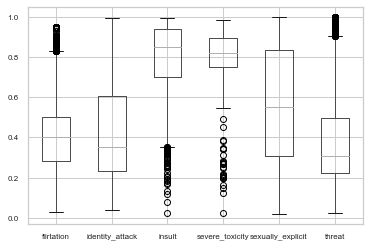

In [393]:
data.iloc[:,0:6].boxplot(fontsize=8)

From the above box plots, I can notice that severe_toxicity and insult features present a few observations which are far from the rest of the data (outside the whiskers of the box plot). Below histograms confirm the analysis

number of obs < 0.4 =  177


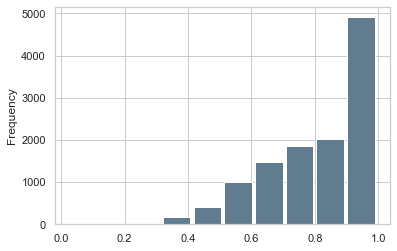

In [394]:
print('number of obs < 0.4 = ',sum(data['insult']<0.4))
data['insult'].plot.hist(grid=True,rwidth=0.9,
                   color='#607c8e')

number of obs < 0.7 =  38


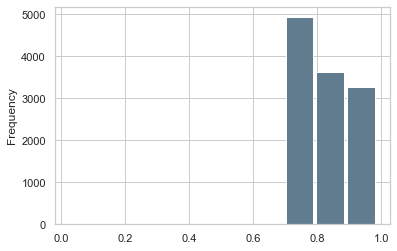

In [395]:
print('number of obs < 0.7 = ',sum(data['severe_toxicity']<0.7))
data['severe_toxicity'].plot.hist(grid=True, rwidth=0.9,
           color='#607c8e')

I decide to remove those outliers from the dataset to improve the analysis and the subsequent implemention of ML algorithms.

New shape is: (11671, 8)
Much better distributions


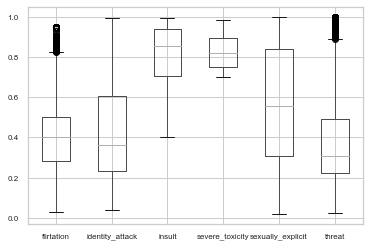

In [396]:
data = data[(data.severe_toxicity>0.7) & (data.insult>0.4)]
print('New shape is:',data.shape)
print('Much better distributions')
data.iloc[:,0:6].boxplot(fontsize=8)

#### 3. ML Approaches

###### 3.1 Split the data into exploratory and response variables

In [397]:
X = data.iloc[:,0:6].values
y = data.iloc[:,7].values # in here we consider the Target variable. The label variable is no longer used
print('The independent features set looks like: ')
print(X[:5,:])
print(100*'#')
print('The dependent variable looks like: ')
print(y[:5])
print(data.iloc[:5,6])

The independent features set looks like: 
[[0.59382784 0.56351614 0.84908956 0.8646318  0.7773473  0.6024943 ]
 [0.21319275 0.40725332 0.92501026 0.856451   0.45698315 0.5929306 ]
 [0.47453213 0.3235741  0.710831   0.7473183  0.9337145  0.20884773]
 [0.5034261  0.4075568  0.7966854  0.8546382  0.95597285 0.34333643]
 [0.39480656 0.17007767 0.5618494  0.76656264 0.45930004 0.22369757]]
####################################################################################################
The dependent variable looks like: 
[0 0 0 1 0]
0         Offensive
1         Offensive
2    Very offensive
3           Neutral
4         Profanity
Name: label, dtype: object


##### 3.2 Compare different ML approaches

Model: LogisticRegression --> score_auc : 0.8875720031374262 - precision : 0.7744437572042592 - recall : 0.37275494672754944 - f1 : 0.5018160788732995
----------------------------------------------------------------------------------------------------
Model: RandomForestClassifier --> score_auc : 0.9177409653544807 - precision : 0.7289926805314876 - recall : 0.4413432267884323 - f1 : 0.5437342741735123
----------------------------------------------------------------------------------------------------
Model: XGBClassifier --> score_auc : 0.9245191140282689 - precision : 0.6703382019974791 - recall : 0.4371765601217656 - f1 : 0.527107002159329
----------------------------------------------------------------------------------------------------
Model: SVM --> score_auc : 0.8535437429667647 - precision : 0.7489447377872775 - recall : 0.4400875190258752 - f1 : 0.5532587961369282
----------------------------------------------------------------------------------------------------


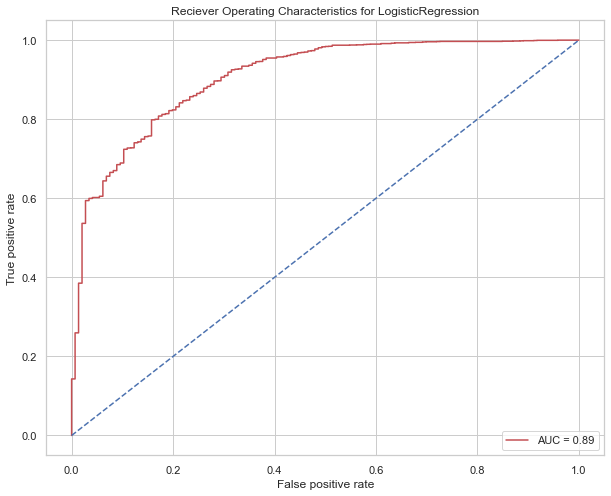

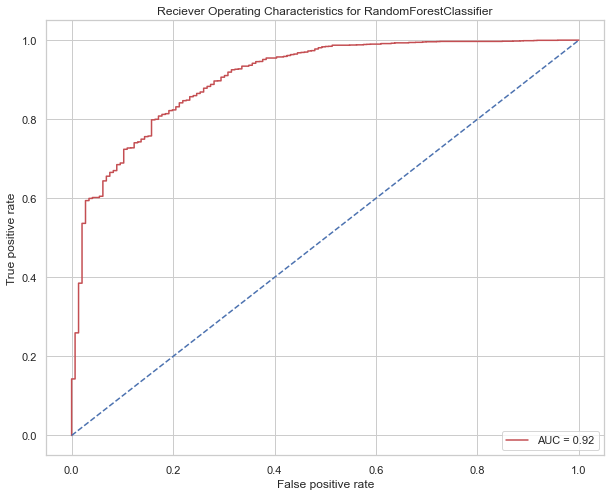

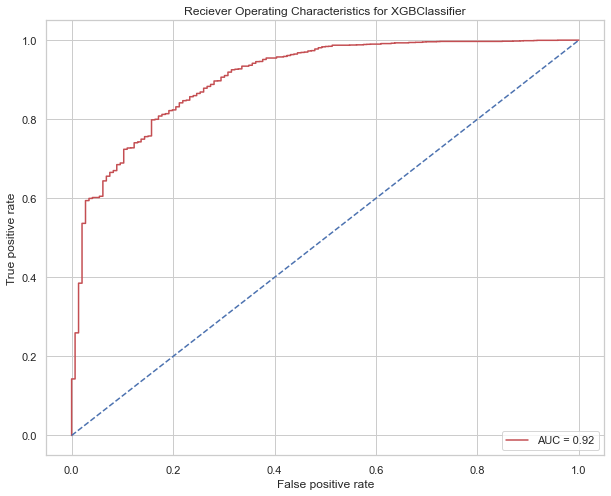

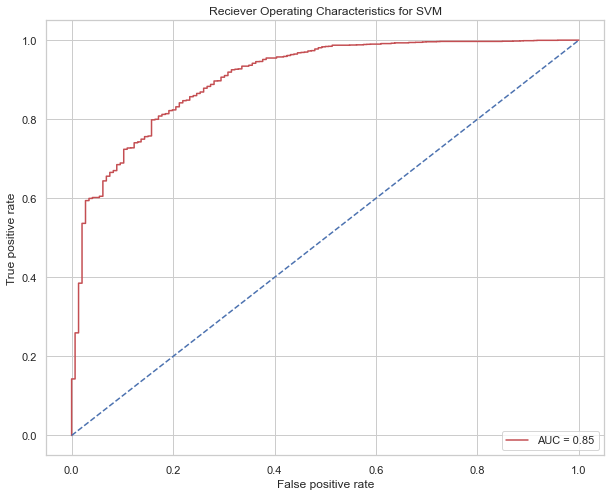

In [398]:
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('XGBClassifier', XGBClassifier()))
models.append(('SVM', SVC()))

# KFold with 'stratify' option to preserve the percentage of samples for each class.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for name, model in models:
    score_auc = cross_val_score(model, X, y, cv=cv, scoring = 'roc_auc')
    score_prec = cross_val_score(model, X, y, cv=cv, scoring = 'precision')
    score_recal = cross_val_score(model, X, y, cv=cv, scoring = 'recall')
    score_f1 = cross_val_score(model, X, y, cv=cv, scoring = 'f1')
    print('Model: {} --> score_auc : {} - precision : {} - recall : {} - f1 : {}'.format(name,score_auc.mean(),\
                                                                                        score_prec.mean(),\
                                                                                        score_recal.mean(),\
                                                                                        score_f1.mean()))
    print(100*'-')
    plt.figure(figsize=(10,8))
    plt.title('Reciever Operating Characteristics for {}'.format(name))
    plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % score_auc.mean())
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')

##### 3.1 Conclusion

- Why Stratified K-Folds

I have used Stratified K-Folds cross-validation which is a variation of kfold that provides train/test indices to split data in train/test sets. Unlike K-folds, Stratified K-Folds returns stratified folds wherein the percentage of samples for each class is preserved. Generally, the StratifiedK-Folds/kFolds cross validation strategies are preferred to the training-test strategy in a production environment when the data available is quite small and it ensures that every observation from the original dataset has the chance of appearing in training and test set.  
With the training-test strategy, there is a possibility of high bias if we are dealing with limited data, because the model would miss some information about the data during the training. Nevertheless, if the data is huge and the test sample and train sample have similar distributions then this approach is preferred.


- Metrics and Best Models

It is not recommended to use accuracy as metric to evaluate models in the case of imbalaced data. Some other metrics can be used like precision, recall, AUC. To determine which one is the best model among the ones implemented, it really depends on the business use case. In this task I would be looking mainly at the AUC. 

In healthcare for example with regards to the sick patient detection (or also claim fraud detection), If a sick patient (Actual Positive) goes through the test and it is predicted by the model as not sick (Predicted Negative) this could have very high consequences if the sickness is contagious (we could think of the Covid-19 swap test for instance).

So if we pay more attention at the AUC metric which measures the ability of the model to distinguish between the classes, then I would choose one of the two tree algorithms (XGBOOST or RandomForest) since they also provide decent recall and precision values.

In the choice between the two algorithms, the gradient boosting algorithm may not be a good choice if we have a lot of noise (for the way it is implemented), as it can result in overfitting. In this data set containing 93% toxic and 7% toxic comments, equal weights  are assigned to all observations during the creation of the first tree.
In each iteration, the weights are updated in order to improve the classification of the previous tree by paying more attention at the previous misclassified observations. By doing so, eventually we end up with a robust classifier which is a combinatin of weak learners.



- Something that I could have tried: Oversampling Techniques

When dealing with imbalanced classification, a technique that can be used in order to let the model effectively learn the decision boundary is to oversample the examples in the minority class (e.g. duplicating observations from the minority class in the training set before fitting a model). As it is true that this technique increases the distribution of the minority class, it is also true that by doing it we do not provide additional information to the model. If we decided to move in the opposite direction, that is undersample observations from the majority class to match the distribution of the minority class, we can end up losing important information about the trimmed class.